# Quick and dirty visualization of the COVID-19 pandemic & a very unscientific logistic regression

In [1]:
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Get and process WHO/ECDC data

Note that we remove China from all considerations, also its contribution to the worldwide data. We do so, because we think that there are multiple reasons it improves our analysis of the data.

In [2]:
#url = "http://cowid.netlify.com/data/full_data.csv"
#url = "https://covid.ourworldindata.org/data/who/full_data.csv"
url = "https://covid.ourworldindata.org/data/ecdc/full_data.csv"
urllib.request.urlretrieve(url, "full_data.csv")
raw_df = pd.read_csv("full_data.csv").sort_values("date", ascending=True)

In [3]:
def get_locational_data(location, drop_location=True, replace_nan=True, reindex=True):
    df_local = raw_df[raw_df['location'] == location].set_index("date")
    if drop_location:
        df_local = df_local.drop(['location'], axis=1)
    if replace_nan:
        df_local = df_local.fillna(0)

    df_local.index = pd.to_datetime(df_local.index, format='%Y-%m-%d')
    if reindex and location != "World" and location != "China":
        earliest_date = get_locational_data("World").index.min()
        newest_date = df_local.index.max()
        idx = pd.date_range(earliest_date, newest_date)
        df_local = df_local.reindex(idx, fill_value=0)

    if location == "World":
        return df_local - get_locational_data("China")
    return df_local

earliest_date = get_locational_data("World").index.min()
newest_date = get_locational_data("World").index.max()
print(f"Our first data point outside China comes from the {earliest_date.date()} and our newest from the {newest_date.date()}.")

Our first data point outside China comes from the 2019-12-31 and our newest from the 2020-03-21.


In [4]:
def get_statistically_informative_locations(min_number_of_total_cases=5000):
    locations = list(raw_df.location.unique())

    informative_locations = []
    for location in locations:
        df_local = get_locational_data(location)

        if location == "China":
            continue
        if df_local.total_cases.max() < min_number_of_total_cases:
            continue

        informative_locations += [location]

    return informative_locations

informative_locations = get_statistically_informative_locations()
print(f"We will focus on the {len(informative_locations)} locations:", ", ".join(informative_locations))

We will focus on the 8 locations: South Korea, Spain, United States, Italy, Iran, World, Germany, France


## Plot ``informative_locations`` to get an overview of the development.

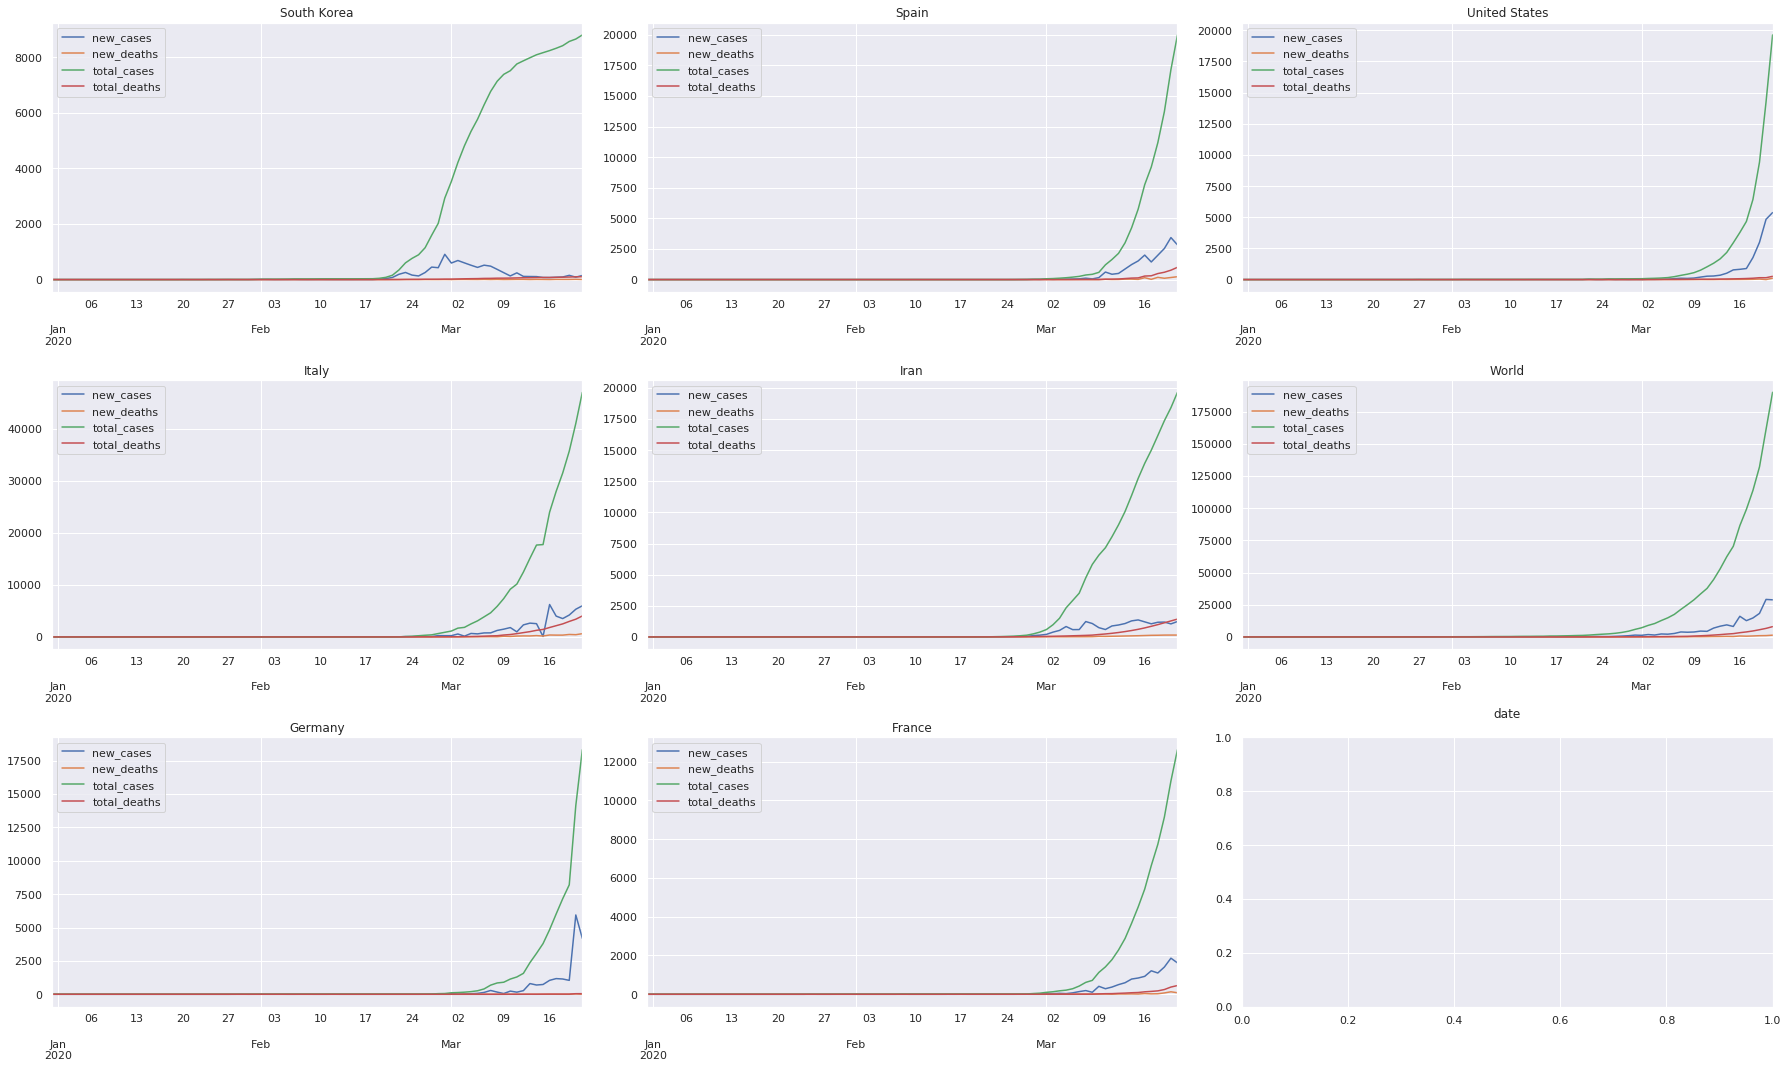

In [5]:
def plot_informative_locations(log_plot=False):
    m = int(np.ceil(np.sqrt(len(informative_locations))))
    n = int(np.ceil(len(informative_locations) / m))
    fig, axes = plt.subplots(m,n, figsize = (25, 15))

    for i, location in enumerate(informative_locations):
        df_local = get_locational_data(location)
        ax = axes[i//n, i%n]
        ax.set_title(location)
        df_local.plot(ax=ax, logy=log_plot)

    fig.tight_layout()
    plt.show()

plot_informative_locations(log_plot=False)

### Log-plot ``informative_locations``

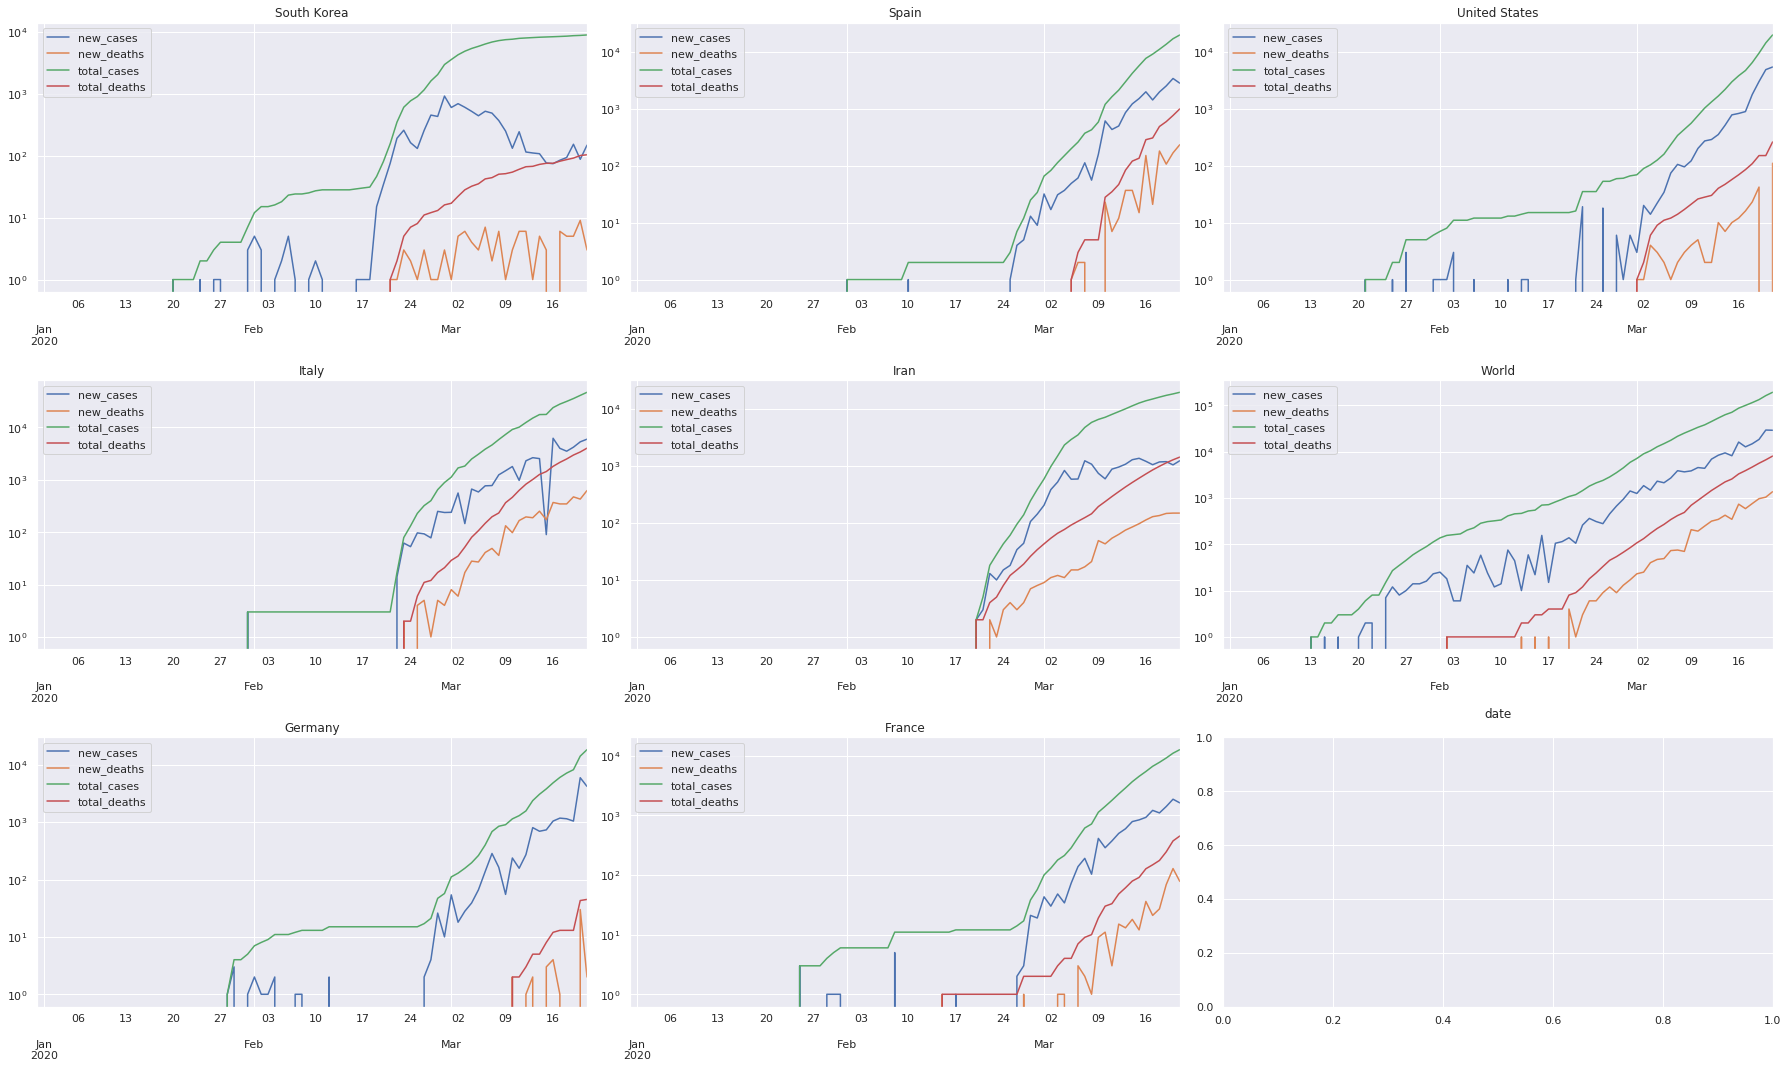

In [6]:
plot_informative_locations(log_plot=True)

### Percentage of ``total_deaths`` over ``total_cases``

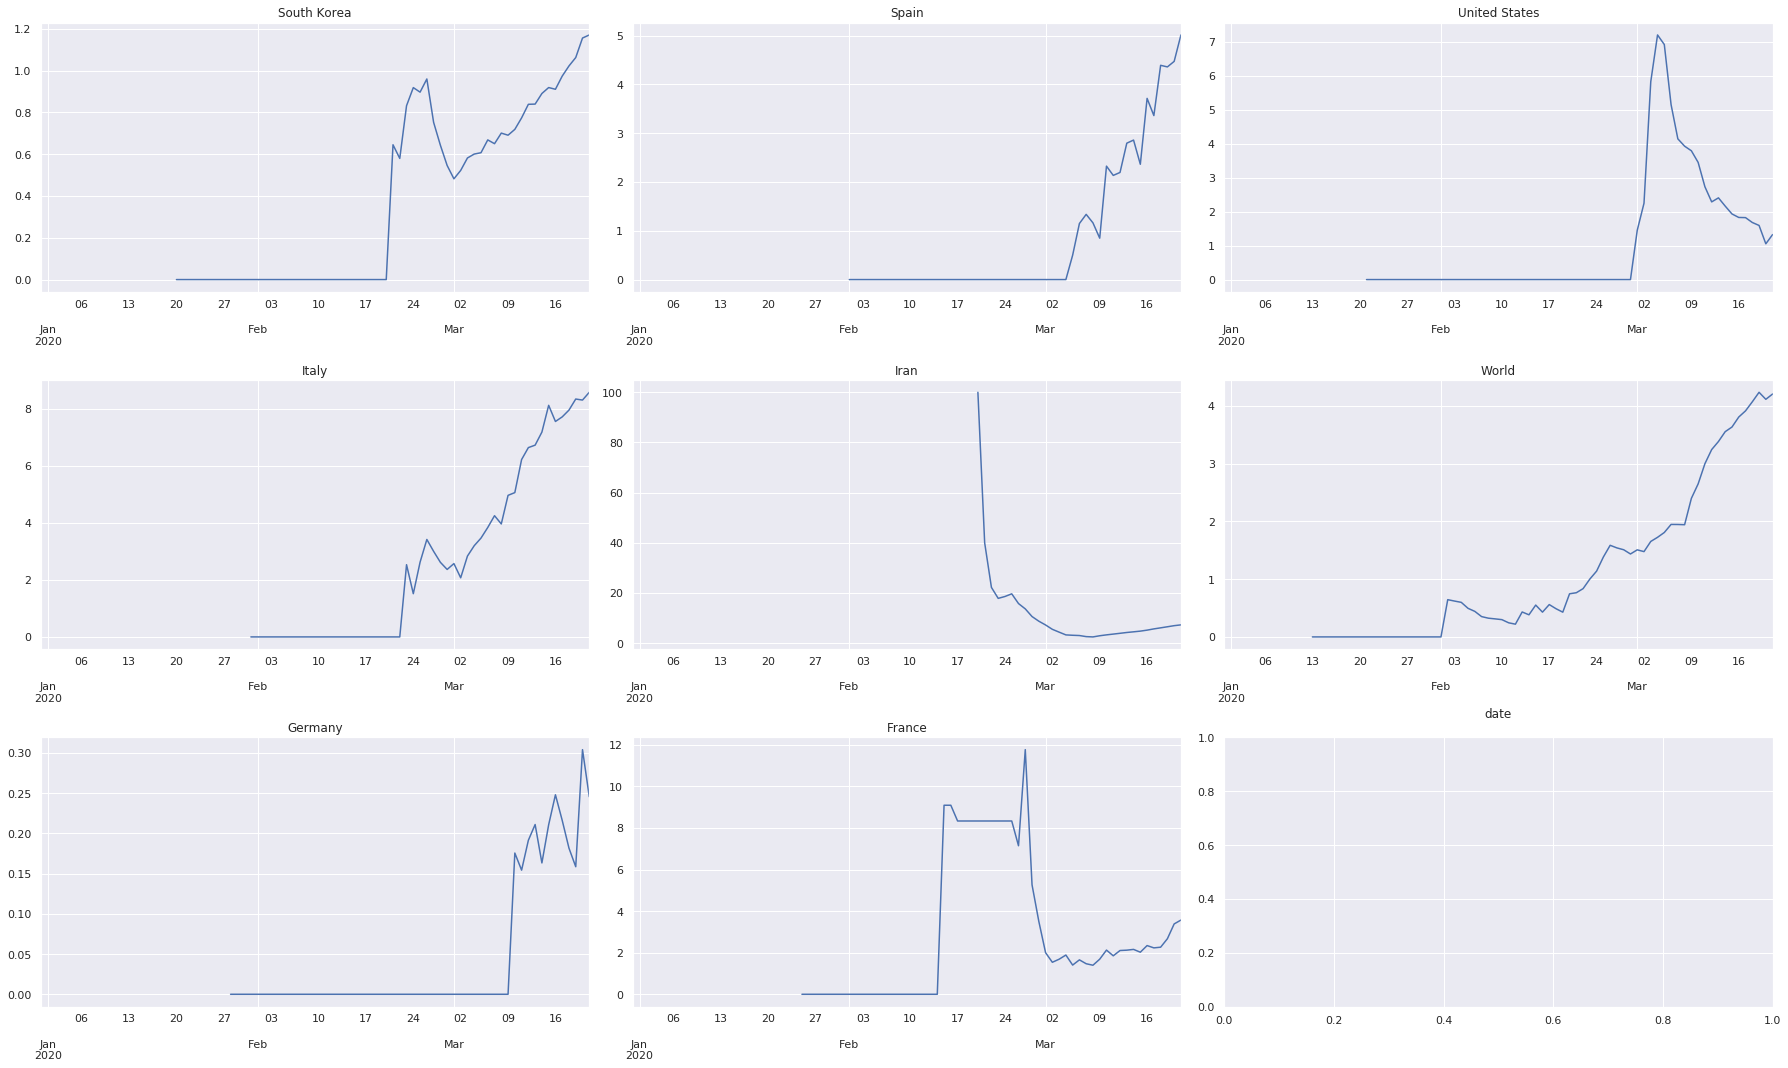

In [7]:
m = int(np.ceil(np.sqrt(len(informative_locations))))
n = int(np.ceil(len(informative_locations) / m))
fig, axes = plt.subplots(m,n, figsize = (25, 15))

for i, location in enumerate(informative_locations):
    df_local = get_locational_data(location)
    df_local = 100 * df_local.total_deaths / df_local.total_cases
    ax = axes[i//n, i%n]
    ax.set_title(location)
    df_local.plot(ax=ax)

fig.tight_layout()
plt.show()

## Code for a regression analysis based on a ``logistic_curve`` using the ``differential_evolution`` optimization

In [8]:
def logistic_curve(curves_maximum_value, growth_rate, midpoint, x):
    """
    Logistic curve, see https://en.wikipedia.org/wiki/Logistic_function
    """
    return curves_maximum_value / (1 + np.exp(-growth_rate*(x-midpoint)))

def get_logistic_curve_loss(curves_maximum_value, growth_rate, midpoint, xs, ys):
    ys_predict = logistic_curve(curves_maximum_value, growth_rate, midpoint, xs)
    loss = np.sum((ys - ys_predict)**2)
    return loss

In [9]:
def fit_logistic_function(xs, ys):
    from scipy.optimize import differential_evolution
    bounds = [(np.max(ys), 7.5e9), (0, 1), (np.min(xs), np.max(xs)+200)]

    loss = lambda parameters: get_logistic_curve_loss(parameters[0], parameters[1], parameters[2], xs, ys)
    result = differential_evolution(loss, bounds)

    best_curves_maximum_value, best_growth_rate, best_midpoint = result['x']
    return best_curves_maximum_value, best_growth_rate, best_midpoint

def get_fit(df_local):
    xs = np.arange(len(df_local))
    ys = df_local['total_cases'].values

    best_curves_maximum_value, best_growth_rate, best_midpoint = fit_logistic_function(xs, ys)

    return best_curves_maximum_value, best_growth_rate, best_midpoint

In [10]:
calendar = pd.date_range('2020-01-21', '2021-01-21').date

In [11]:
def plot_prediction(location, x_ticks_subsampling=1):
    df_local = get_locational_data(location)
    best_curves_maximum_value, best_growth_rate, best_midpoint = get_fit(df_local)
    info_str = f"Predictions for {location}:\n" \
             + f"Final number of infected: {int(round(best_curves_maximum_value))}\n" \
             + f"with a maximal number of newly infected {int(round(best_curves_maximum_value*best_growth_rate))}\n" \
             + f"at the {calendar[int(round(best_midpoint))]}."

    xs = np.arange(len(df_local))
    ys = df_local['total_cases'].values
    ys_predict = logistic_curve(best_curves_maximum_value, best_growth_rate, best_midpoint, xs)

    print(best_curves_maximum_value, best_growth_rate, best_midpoint)
    plt.title(info_str)
    plt.plot(xs, ys, c='b')
    plt.plot(xs, ys_predict, c='b', linestyle='dashed')
    xs_ticks = xs[::x_ticks_subsampling]
    plt.xticks(xs_ticks, calendar[xs_ticks], rotation="vertical")
    fig = plt.gcf()
    fig.set_size_inches(20,2)
    plt.show()

## Do and plot the regression analysis  for ``informative_locations``.

4454829921.327925 0.06471657922410821 280.13682603097783


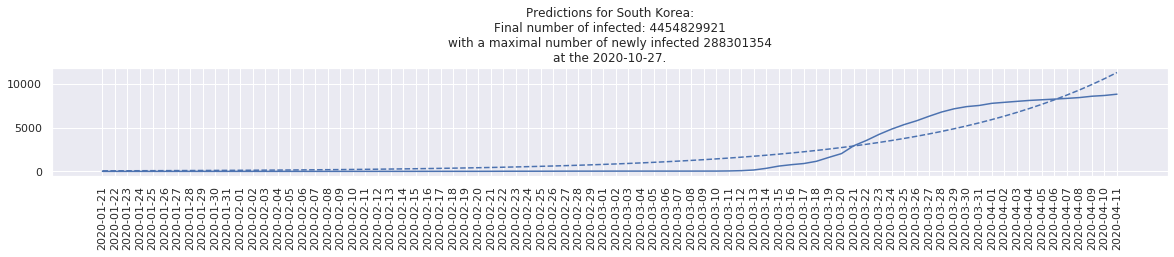

5053787244.1271515 0.22583170225027835 135.8675058894766


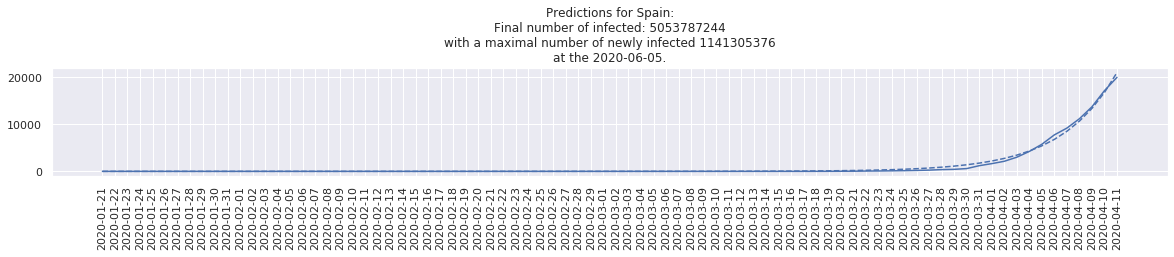

4855800940.840555 0.33752490720639183 117.81703579512285


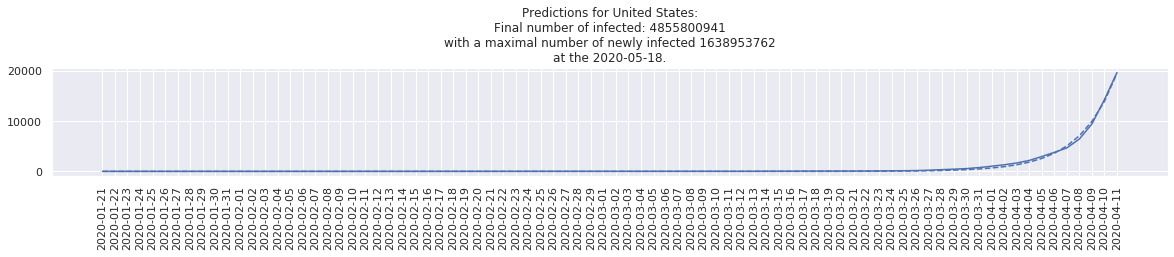

4337040922.212534 0.1557166217826571 154.19880804115027


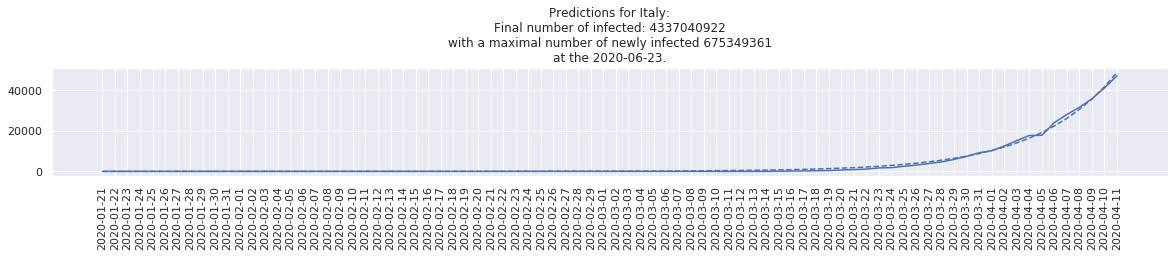

2683511377.953518 0.11393947315671549 183.7798284629426


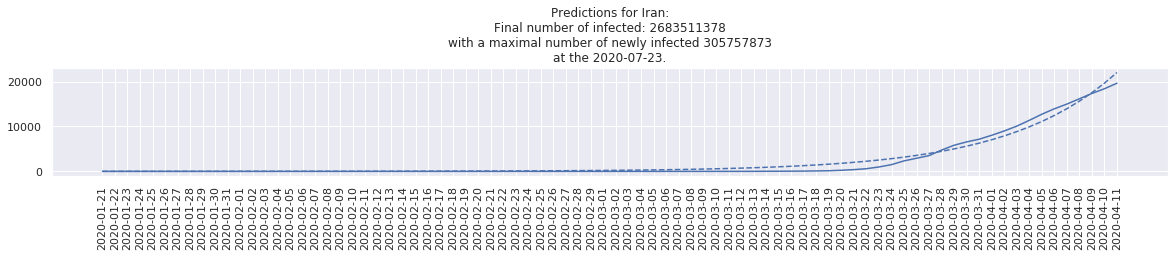

5225854442.692055 0.15996103933041514 144.97899726681817


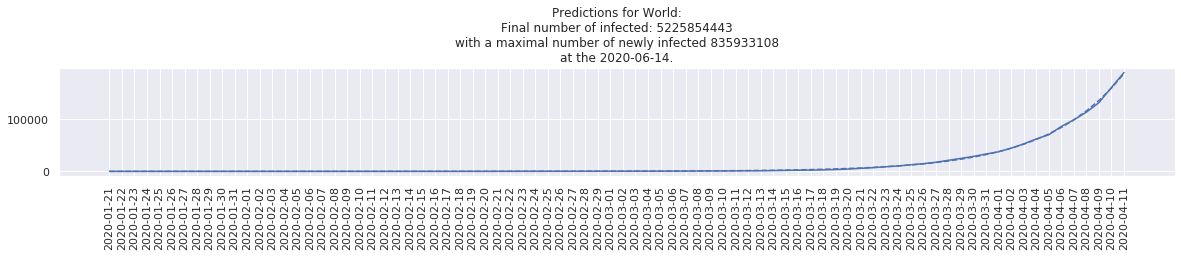

2884621871.224447 0.2756990981899786 124.5179114342092


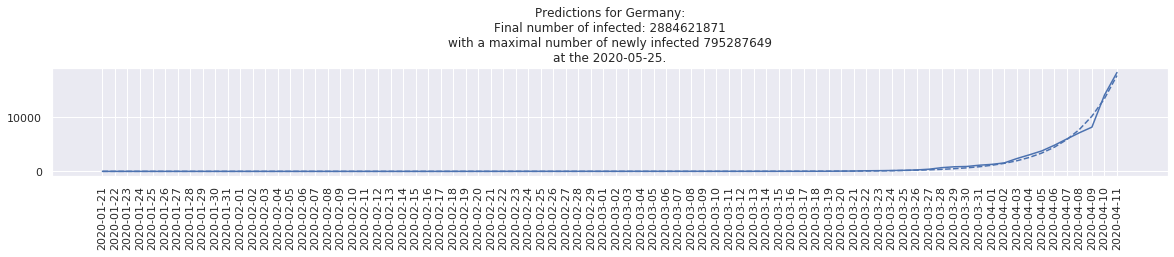

4959562007.840168 0.19022349072807315 148.48707984518086


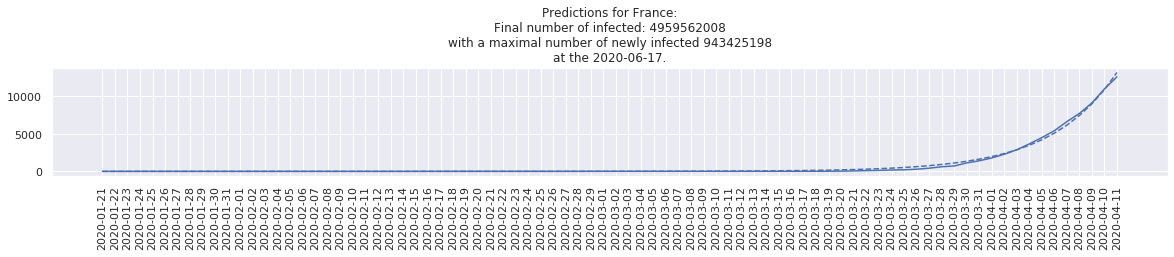

In [12]:
for location in informative_locations:
    plot_prediction(location)

# Note that until we are in the saturation phase, all long term predictions (like the final number of infected people) are essentially worthless (see ill-posedness/instability).